

# Evolution of emotions conveyed by media and their link with the society state

## PROJECT - MILESTONE 2

In [1]:
import matplotlib.pyplot as plt
from pyspark.sql.types import *
import datetime as dt
from pyspark.sql.functions import *
import pandas as pd
import numpy as np
import scipy as sp
from pyspark.sql import *
%matplotlib inline
import seaborn as sn
sn.set(color_codes=True)
spark = SparkSession.builder.getOrCreate()

<img src="query_avgToneBySourceLocation.png" alt="drawing" width="500"/>

In [18]:
#avgTone = spark.read.option("sep",",").option('header', 'true').csv("sourceCountry_AvgTone.csv")
avgTone = spark.read.option("sep",",").option('header', 'true').csv("avgToneBySourceLocation_table.csv")
avgTone.show()
avgTone = avgTone.withColumn('AverageTone', avgTone['AverageTone'].cast(FloatType()))
avgTone.registerTempTable('avgTone_table')

+----+--------------------+
|FIPS|         AverageTone|
+----+--------------------+
|  IT| -1.2266319517342155|
|  WA| -2.1564389385620708|
|  CM| -2.9449712401336963|
|  ML| -1.4626035850125303|
|  MG|-0.24210924465101621|
|  PK| -2.9042192814547048|
|  GH| -1.9078195733342607|
|  KZ| -1.2593573700554748|
|  BM|  -2.257738120596255|
|  IN| -2.6352216561258954|
|  MI| -2.1356432264451626|
|  AV|  1.6529235384892216|
|  LT| -1.7559838499012681|
|  GB|-0.75436355420488421|
|  UK| -2.4232246650674325|
|  AU| -2.9686971461863192|
|  CK| -2.7693001028740176|
|  RS| -2.3112888288017395|
|  TW| -2.4235868152902853|
|  RI|  -1.003833159575332|
+----+--------------------+
only showing top 20 rows



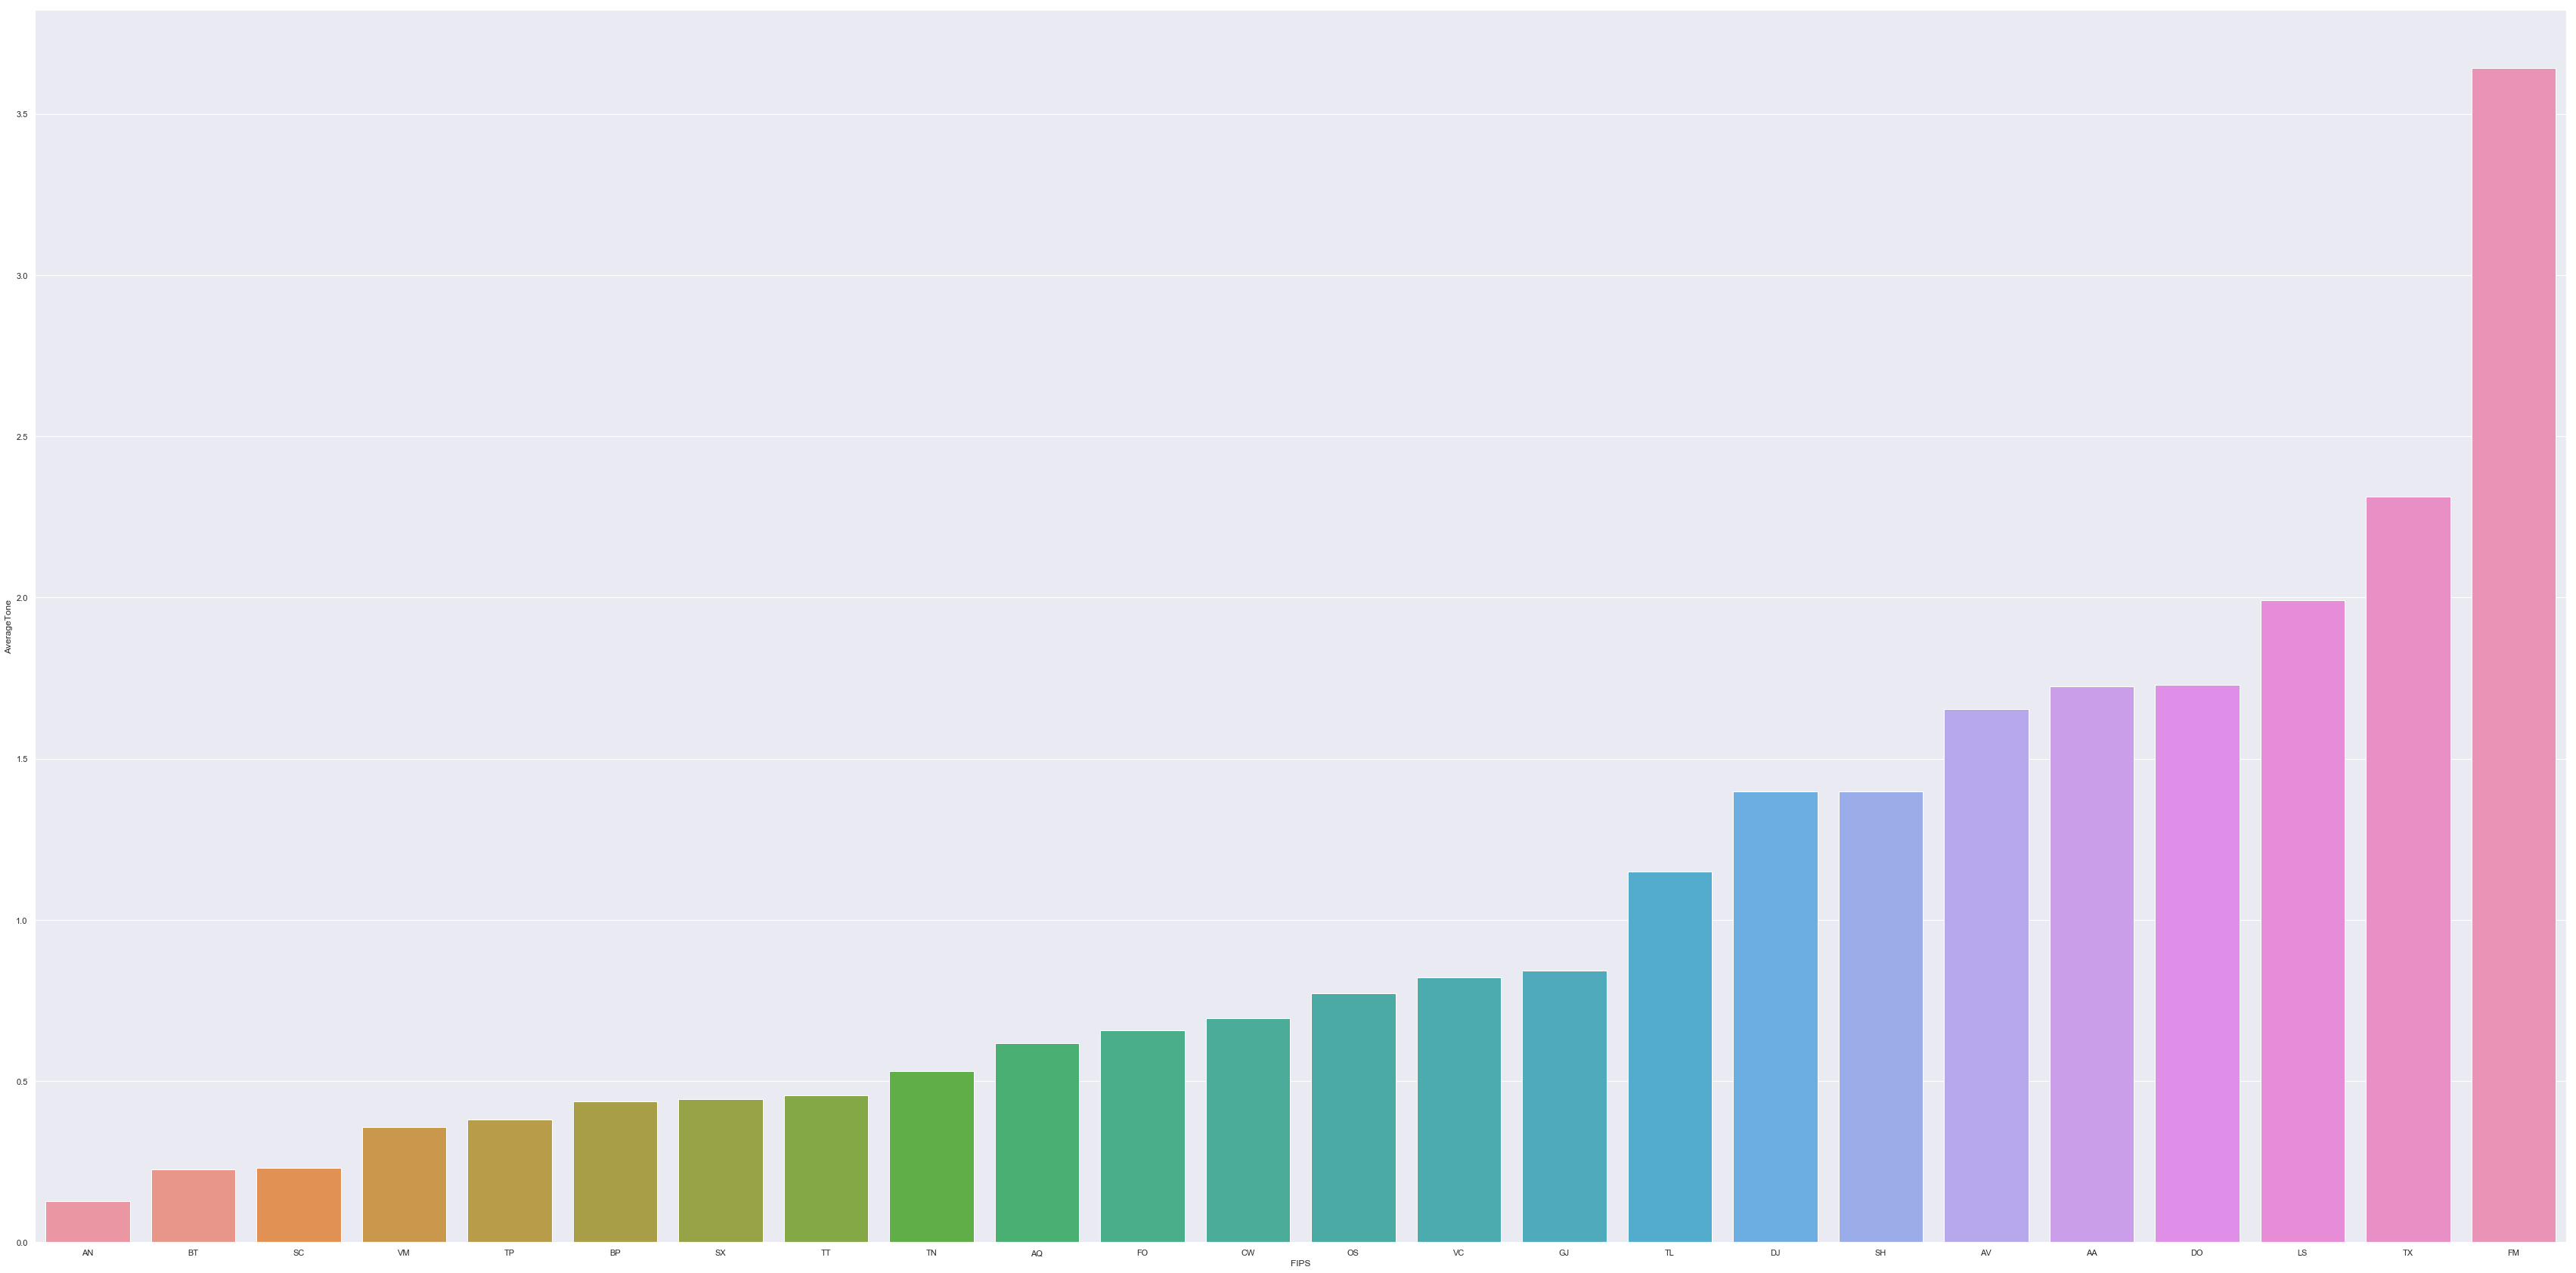

In [19]:
avgTone_pos = avgTone.filter('AverageTone > 0')
avgTone_pos_pandas = avgTone_pos.toPandas()
avgTone_pos_pandas.sort_values('AverageTone', ascending=True, inplace=True)

sn.set(rc={'figure.figsize':(60,30)})
plot = sn.barplot(x='FIPS', y='AverageTone',data=avgTone_pos_pandas)
fig = plot.get_figure()
fig.savefig("plot_positiveAvgTone.png")

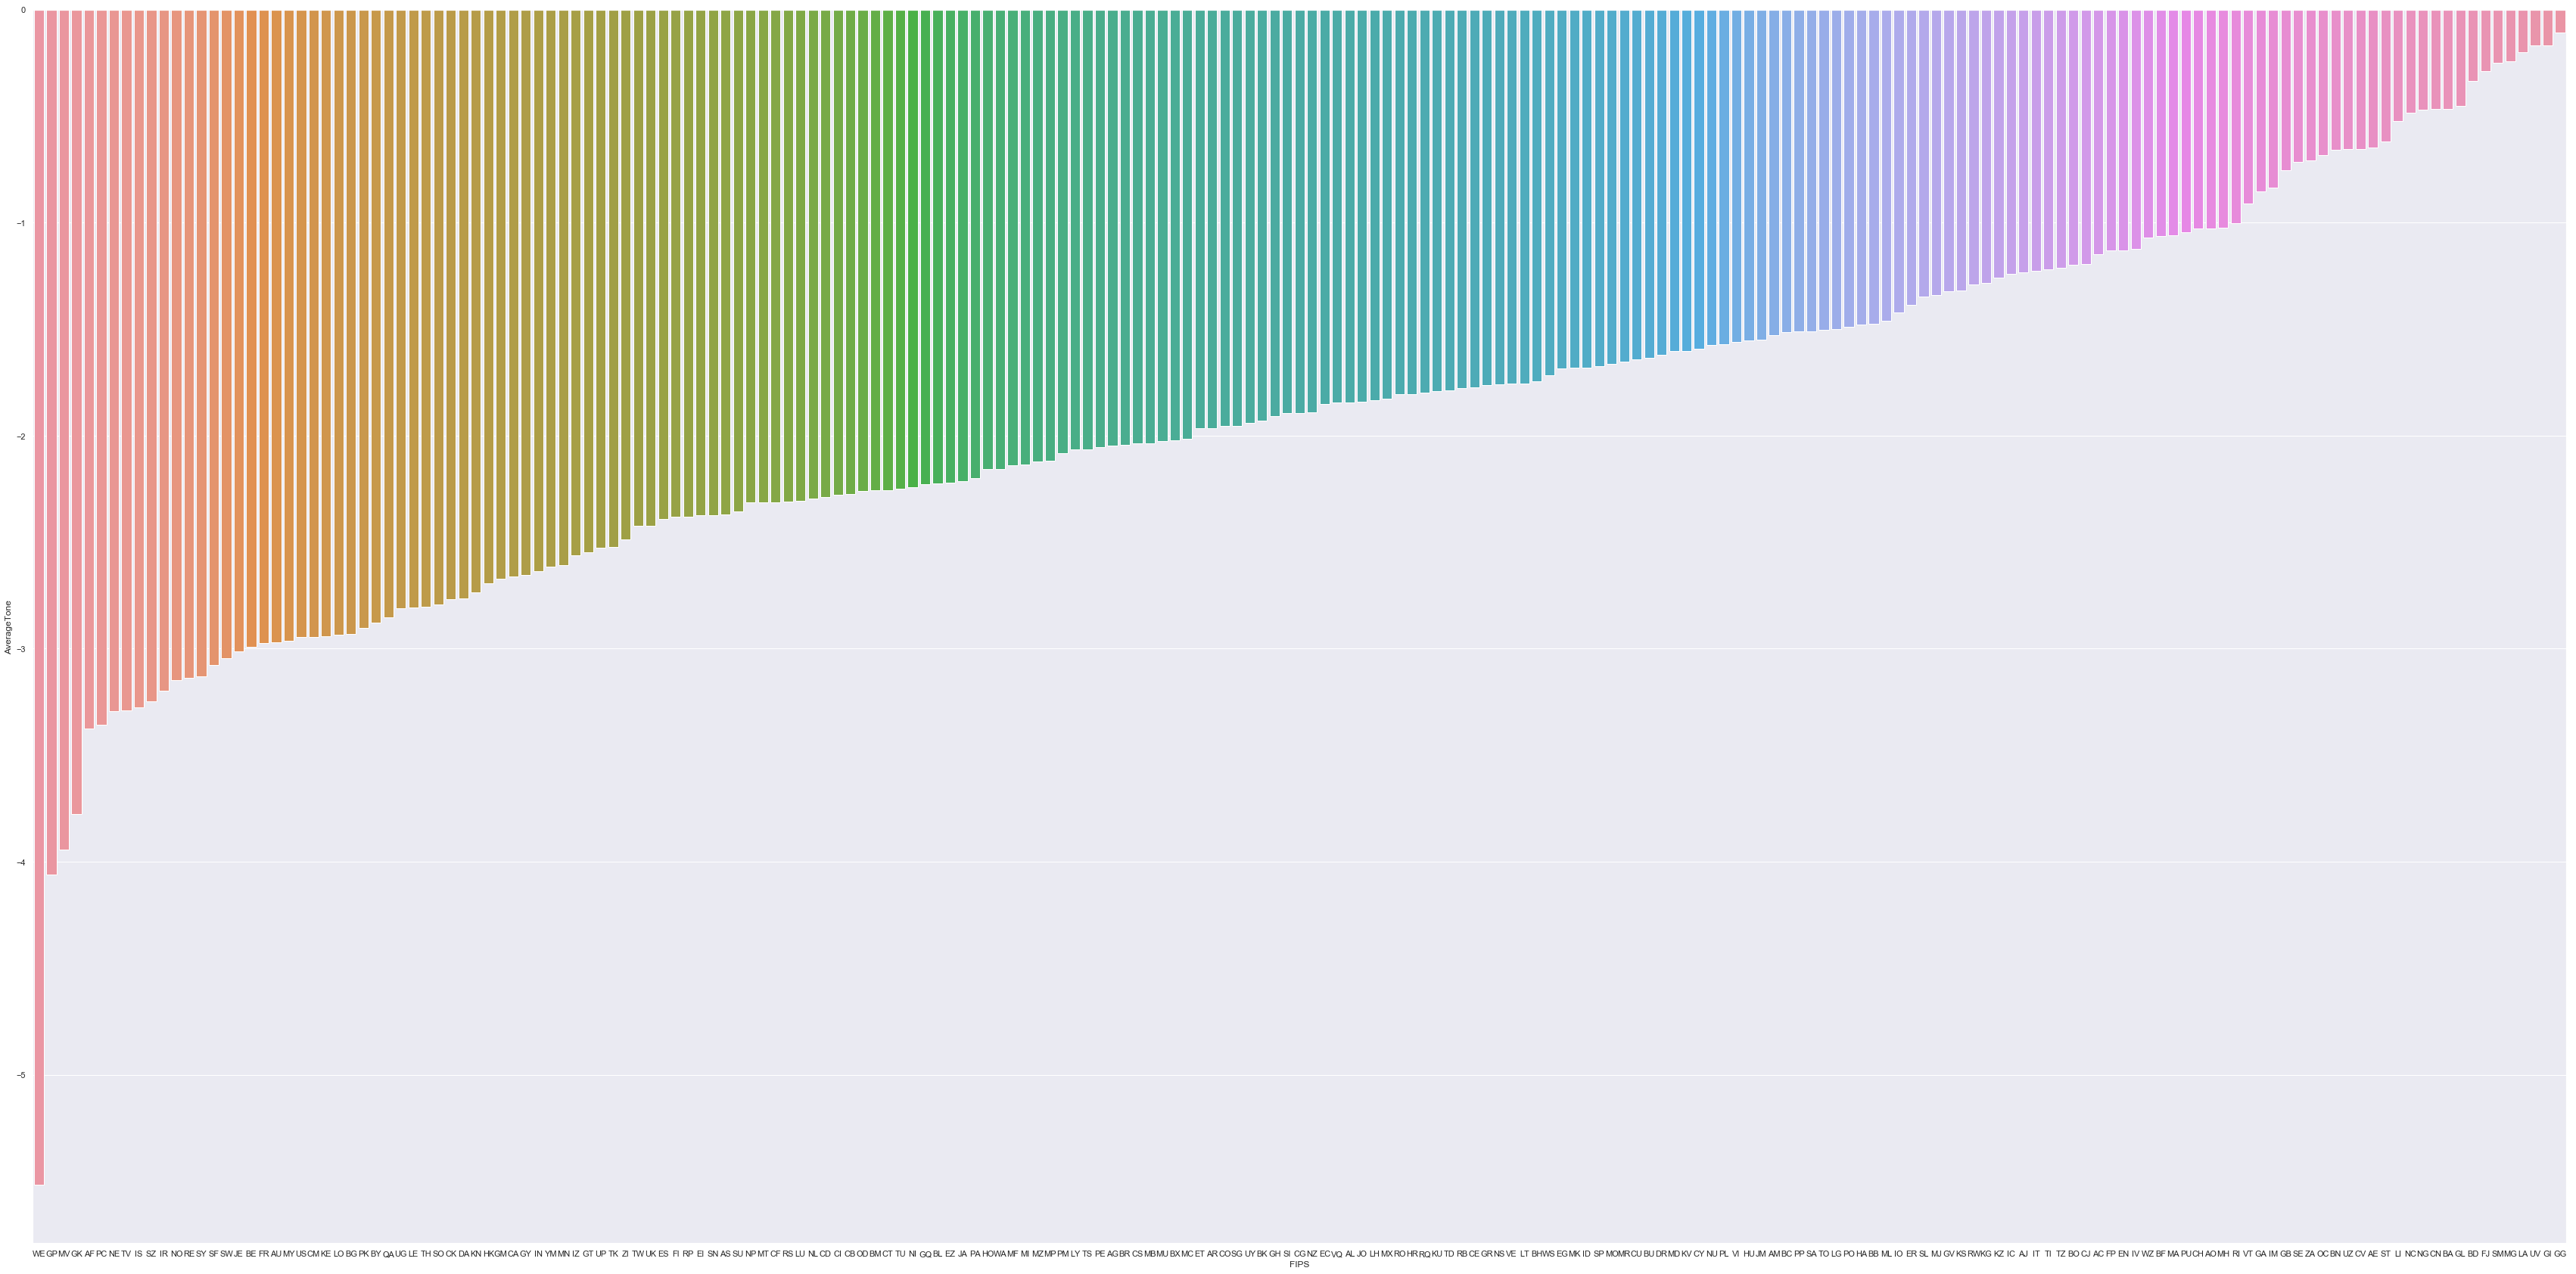

In [20]:
avgTone_neg = avgTone.filter('AverageTone <= 0')
avgTone_neg_pandas = avgTone_neg.toPandas()
avgTone_neg_pandas.sort_values('AverageTone', ascending=True, inplace=True)

sn.set(rc={'figure.figsize':(60,30)})
plot = sn.barplot(x='FIPS', y='AverageTone',data=avgTone_neg_pandas)
fig = plot.get_figure()
fig.savefig("plot_negativeAvgTone.png")

In [21]:
happiness = spark.read.option("sep", ";").option('header', 'true').csv("HappinessCustom.csv")\
    .select('FIPS', 'Happiness_score').dropna()
    
happiness = happiness.withColumn('Happiness_score', happiness["Happiness_score"].cast(FloatType()))
print(happiness.dtypes)
happiness.show()
happiness.registerTempTable("happiness_table")

[('FIPS', 'string'), ('Happiness_score', 'float')]
+----+---------------+
|FIPS|Happiness_score|
+----+---------------+
|  FI|          7.632|
|  NO|          7.594|
|  DK|          7.555|
|  IC|          7.495|
|  SZ|          7.487|
|  NL|          7.441|
|  CA|          7.328|
|  NZ|          7.324|
|  SW|          7.314|
|  AS|          7.272|
|  IS|           7.19|
|  AU|          7.139|
|  CS|          7.072|
|  EI|          6.977|
|  GM|          6.965|
|  BE|          6.927|
|  LU|           6.91|
|  US|          6.886|
|  UK|          6.814|
|  AE|          6.774|
+----+---------------+
only showing top 20 rows



In [22]:
query = """
select happiness_table.FIPS, Happiness_score, AverageTone
from happiness_table
inner join avgTone_table
on happiness_table.FIPS = avgTone_table.FIPS
"""

joinedTable = spark.sql(query)
joinedTable.show()

+----+---------------+-----------+
|FIPS|Happiness_score|AverageTone|
+----+---------------+-----------+
|  IT|            6.0|  -1.226632|
|  WA|          4.441| -2.1564388|
|  CM|          4.975| -2.9449713|
|  ML|          4.447| -1.4626036|
|  MG|          5.125|-0.24210924|
|  PK|          5.472| -2.9042194|
|  GH|          4.657| -1.9078196|
|  KZ|           5.79| -1.2593573|
|  IN|           4.19| -2.6352217|
|  MI|          3.587| -2.1356432|
|  LT|          3.808| -1.7559838|
|  GB|          4.758|-0.75436354|
|  UK|          6.814| -2.4232247|
|  AU|          7.139|  -2.968697|
|  RS|           5.81| -2.3112888|
|  TW|          6.441| -2.4235868|
|  BG|            4.5| -2.9303584|
|  IC|          7.495| -1.2405035|
|  ET|           4.35| -1.9656553|
|  UP|          4.103| -2.5247657|
+----+---------------+-----------+
only showing top 20 rows



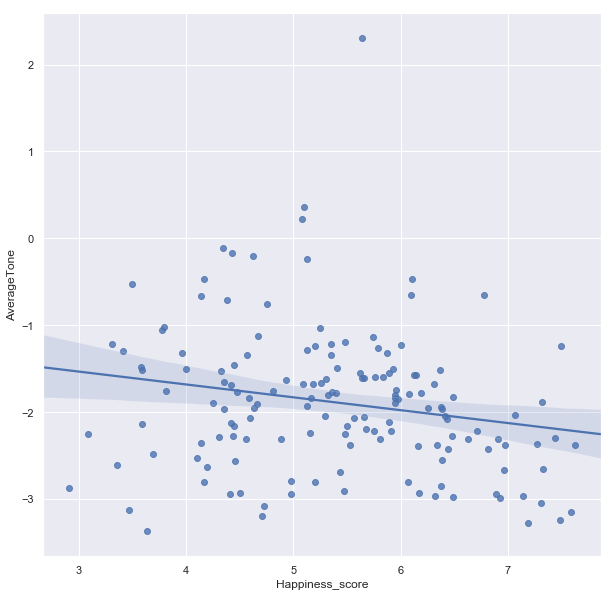

In [23]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] =10
plt.rcParams["figure.figsize"] = fig_size

joined_df = joinedTable.toPandas()
sn.regplot(x='Happiness_score', y='AverageTone', data=joined_df)

In [24]:
pearson_coef = joined_df['Happiness_score'].corr(joined_df['AverageTone'])
print(pearson_coef)

-0.19776258027613083
